# 1D Heat Equation

In [1]:
import m228
import emme as em
import anon
import jax
# anon.conf.config.update('jax_disable_jit', True)
import anon.atom as anp
import numpy as np
from anon import quad,step
import matplotlib.pyplot as plt
plt.style.use("typewriter")
SAVE_FIGS = True
from elle_0001 import elem_0001

In [2]:
alpha = 1/100
a1 = -alpha
f = lambda x: anp.pi**2/100*sum(anp.sin((2*k+1)*anp.pi*x) for k in range(5))

pi = anp.pi
sin = anp.sin
cos = anp.cos
exp = anp.exp
def cn(t):
    return [
        pi**2*(pi*alpha*sin(pi*t)/(pi**3*alpha**2 + pi) - cos(pi*t)/(pi**3*alpha**2 + pi))/100 + pi**2/(100*(pi**3*alpha**2*exp(pi**2*alpha*t) + pi*exp(pi**2*alpha*t))), 
        pi**2*(9*pi*alpha*sin(pi*t)/(81*pi**3*alpha**2 + pi) - cos(pi*t)/(81*pi**3*alpha**2 + pi))/100 + pi**2/(100*(81*pi**3*alpha**2*exp(9*pi**2*alpha*t) + pi*exp(9*pi**2*alpha*t))), 
        pi**2*(25*pi*alpha*sin(pi*t)/(625*pi**3*alpha**2 + pi) - cos(pi*t)/(625*pi**3*alpha**2 + pi))/100 + pi**2/(100*(625*pi**3*alpha**2*exp(25*pi**2*alpha*t) + pi*exp(25*pi**2*alpha*t))), 
        pi**2*(49*pi*alpha*sin(pi*t)/(2401*pi**3*alpha**2 + pi) - cos(pi*t)/(2401*pi**3*alpha**2 + pi))/100 + pi**2/(100*(2401*pi**3*alpha**2*exp(49*pi**2*alpha*t) + pi*exp(49*pi**2*alpha*t))), 
        pi**2*(81*pi*alpha*sin(pi*t)/(6561*pi**3*alpha**2 + pi) - cos(pi*t)/(6561*pi**3*alpha**2 + pi))/100 + pi**2/(100*(6561*pi**3*alpha**2*exp(81*pi**2*alpha*t) + pi*exp(81*pi**2*alpha*t)))
     ]

def u(x,t):
    c = cn(t)
    return sum( c[n] * anp.sin(xi*x)
        for n,xi in enumerate([(2*k+1)*anp.pi for k in range(5)])
    ) 


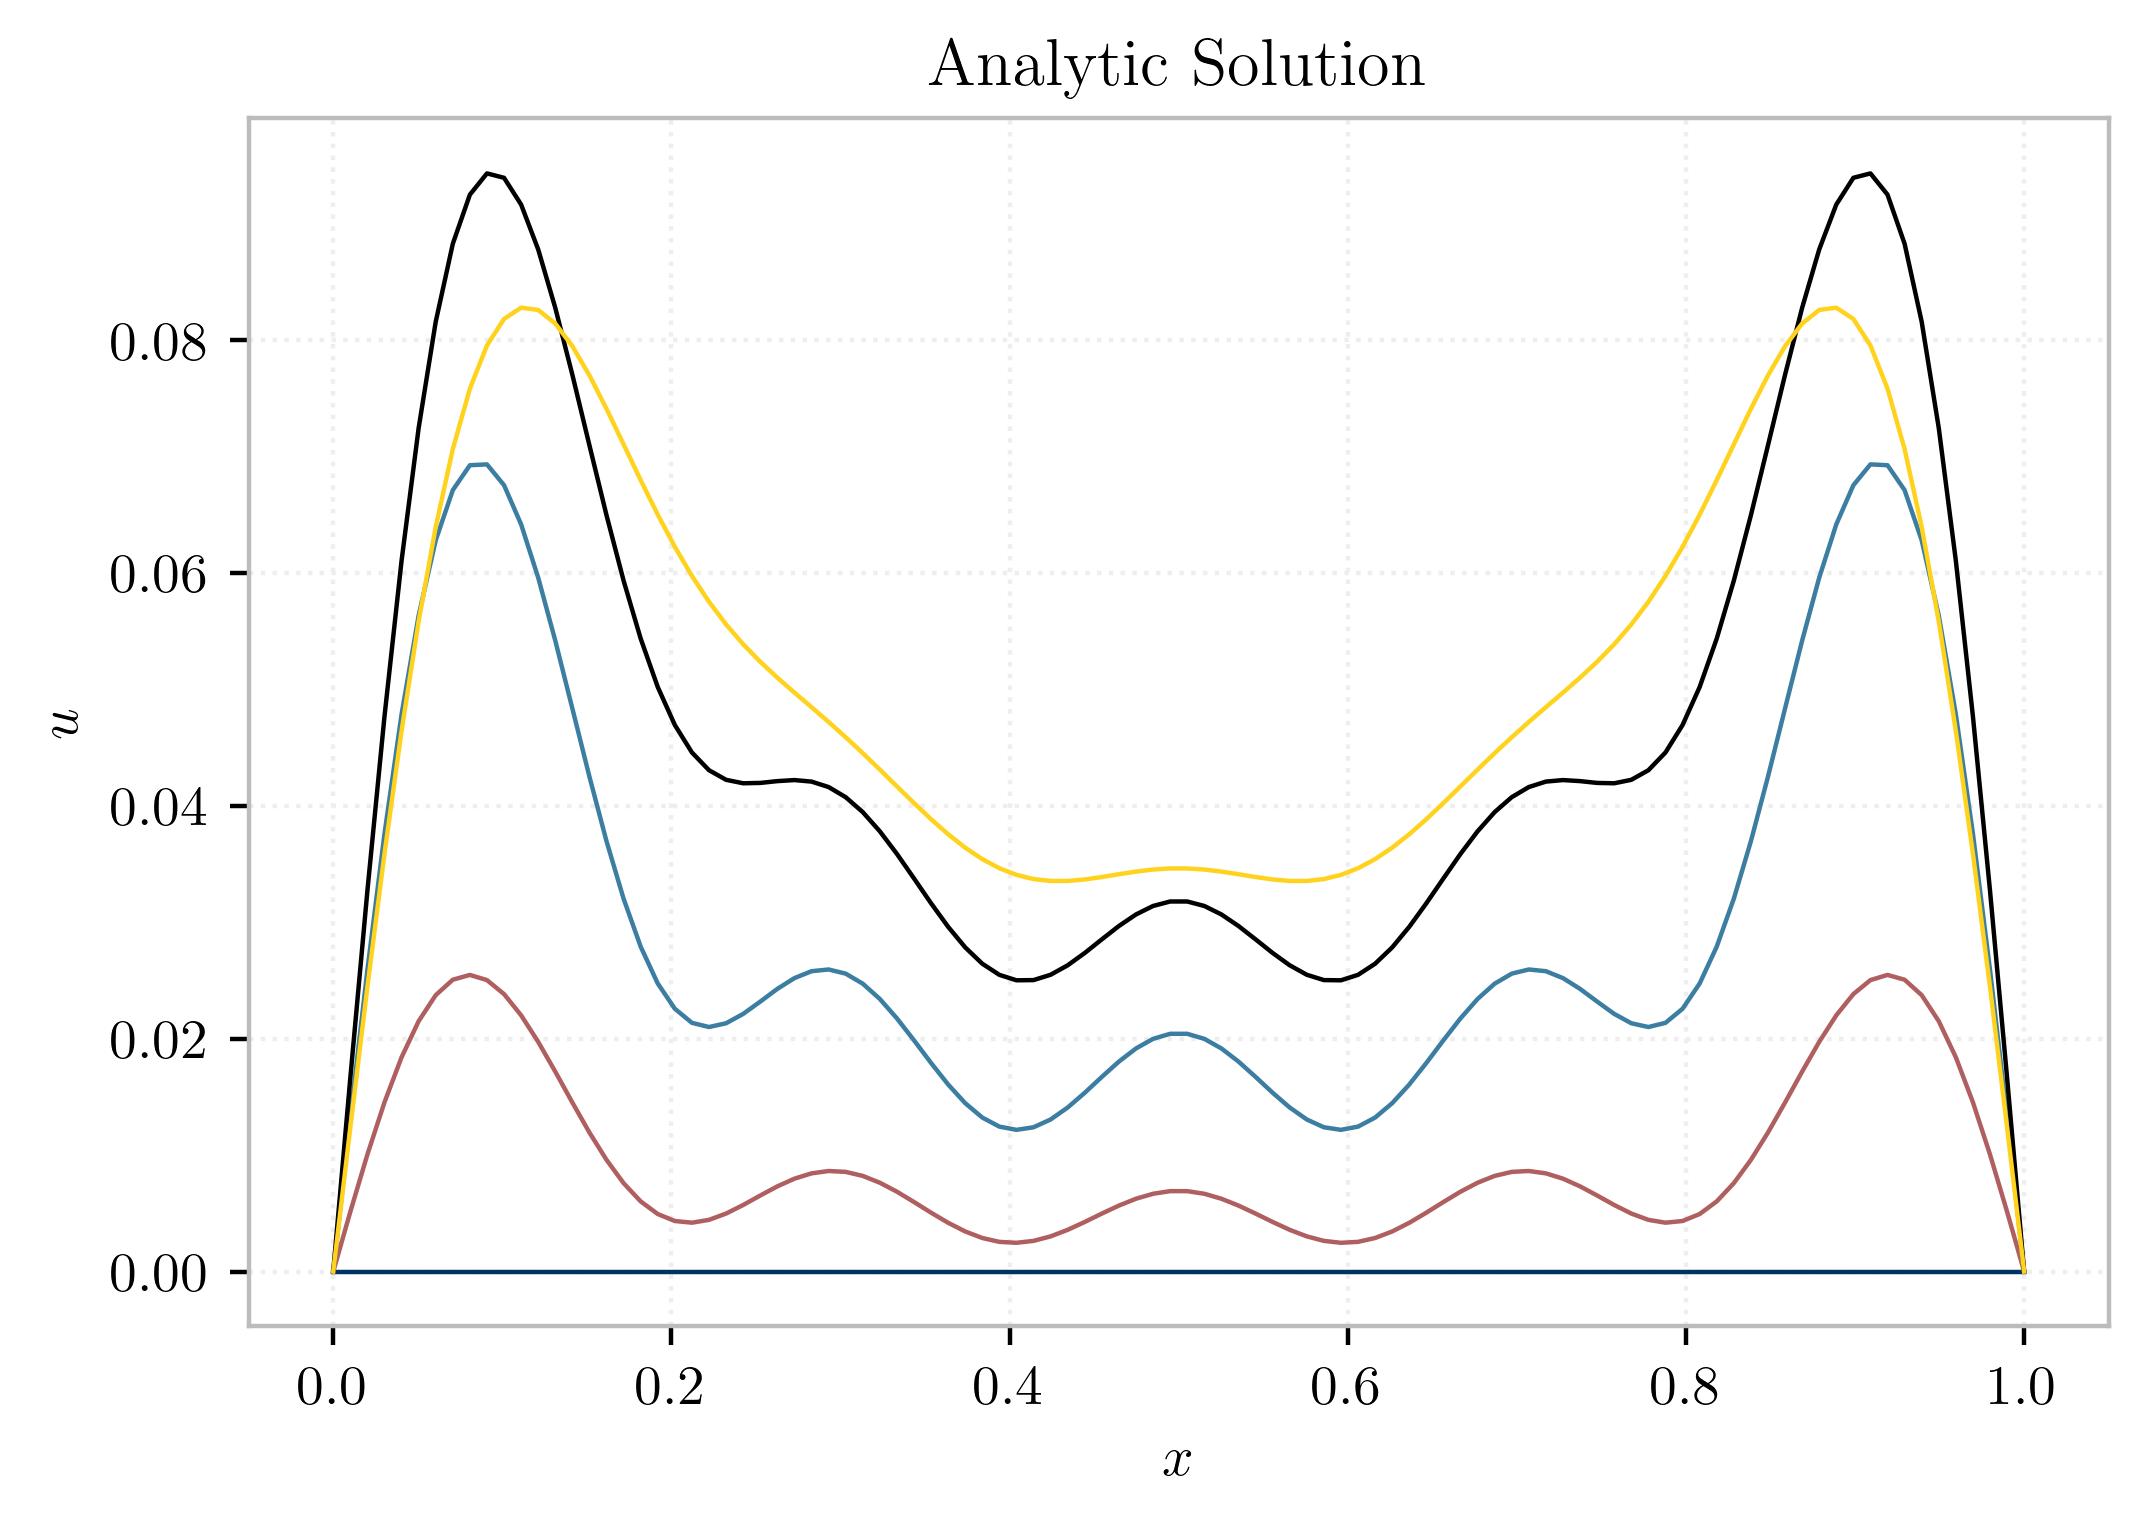

In [3]:
fig, ax = plt.subplots()
nx,nt = 100,5
dt = 1/(nt-1)

x = anp.linspace(0,1,nx)
for n in range(nt):
    ax.plot(x, u(x,n*dt))
ax.set_title("Analytic Solution")
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
if SAVE_FIGS: fig.savefig("./img/p3b-exact.png")

In [4]:
tableau = dict(
    A = (
        [  1./4.],
        [  1./2.,       1./4.],
        [ 17./50.,     -1./25.,    1./4. ],
        [371./1369., -137./2720., 15./544.,   1./4.],
        [ 25./24.,    -49./48.,   125./16., -85./12., 1./4.]
    ),
    b = [ 25./24.,    -49./48.,   125./16., -85./12., 1./4.],
    c = [  1/4   ,      3./4. ,    11./20.,   1./2. ,  1.0 ]
)

In [5]:
model = em.SkeletalModel(1,1)
a1 = model.param("a1")
a2 = model.param("a2")
elem = elem_0001(f, a1, a2, order=9)

In [23]:
def build(nel):
    model.clean(keep=["params"])
    L = 1.0
    nen = 5
    tag = 1
    model.node('1.1',0)
    for i in range(nel):
        nodes = [model.nodes[-1]]
        for j in range(1,nen):
            nodes.append(model.node(f"{i+1}.{j+1}", i*L/nel + (j)*(L/nel)/(nen-1)))
        model.elem(elem,nodes,f"{i}")
    model.boun("1.1", [1])
    model.boun(f"{nel}.{nen}", [1])
    
    f_ = model.compose_force()
    f__ = f_(1/100,0)
    jacf = f_.jacx
    M = jacf(0.,1.)
#     f__ = np.array([[f(node.x)] for node in model.nodes[1:-1]])
    Mi = anp.linalg.inv(M)
    A = Mi@jacf(1/100,0.)
    
    return f__, Mi, A

def solve(dt,*model_vars):
    f__, Mi, A = model_vars
    U = anp.zeros((model.nf,3))
    stepper = jax.jit(step.rk_lin(dt,tableau,A,lambda t: f__*anp.sin(t*anp.pi),tridiag=False)["step"])
    X = [n.x for n in model.nodes[1:-1]]
    t = 0.0
    nt = int(1/dt)+1
    U = np.zeros((model.nf*nt,3))
    u = anp.zeros((model.nf,1))
    nf = model.nf
    for i in range(nt):
        u = stepper(u,t)
        print(i)
        U[i*nf: nf*(i+1), 2] = u.flatten()
        U[i*nf: nf*(i+1), 1] = t
        U[i*nf: nf*(i+1), 0] = X
        t = t + dt
    return U

def build_and_run(dt,nel):
    model = build(nel)
    return solve(dt,model)

In [27]:
model_vars = build(6)

In [28]:
U = solve(0.01,*model_vars)

True
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


(<Figure size 4000x1600 with 1 Axes>, <Axes3DSubplot:xlabel='x', ylabel='t'>)

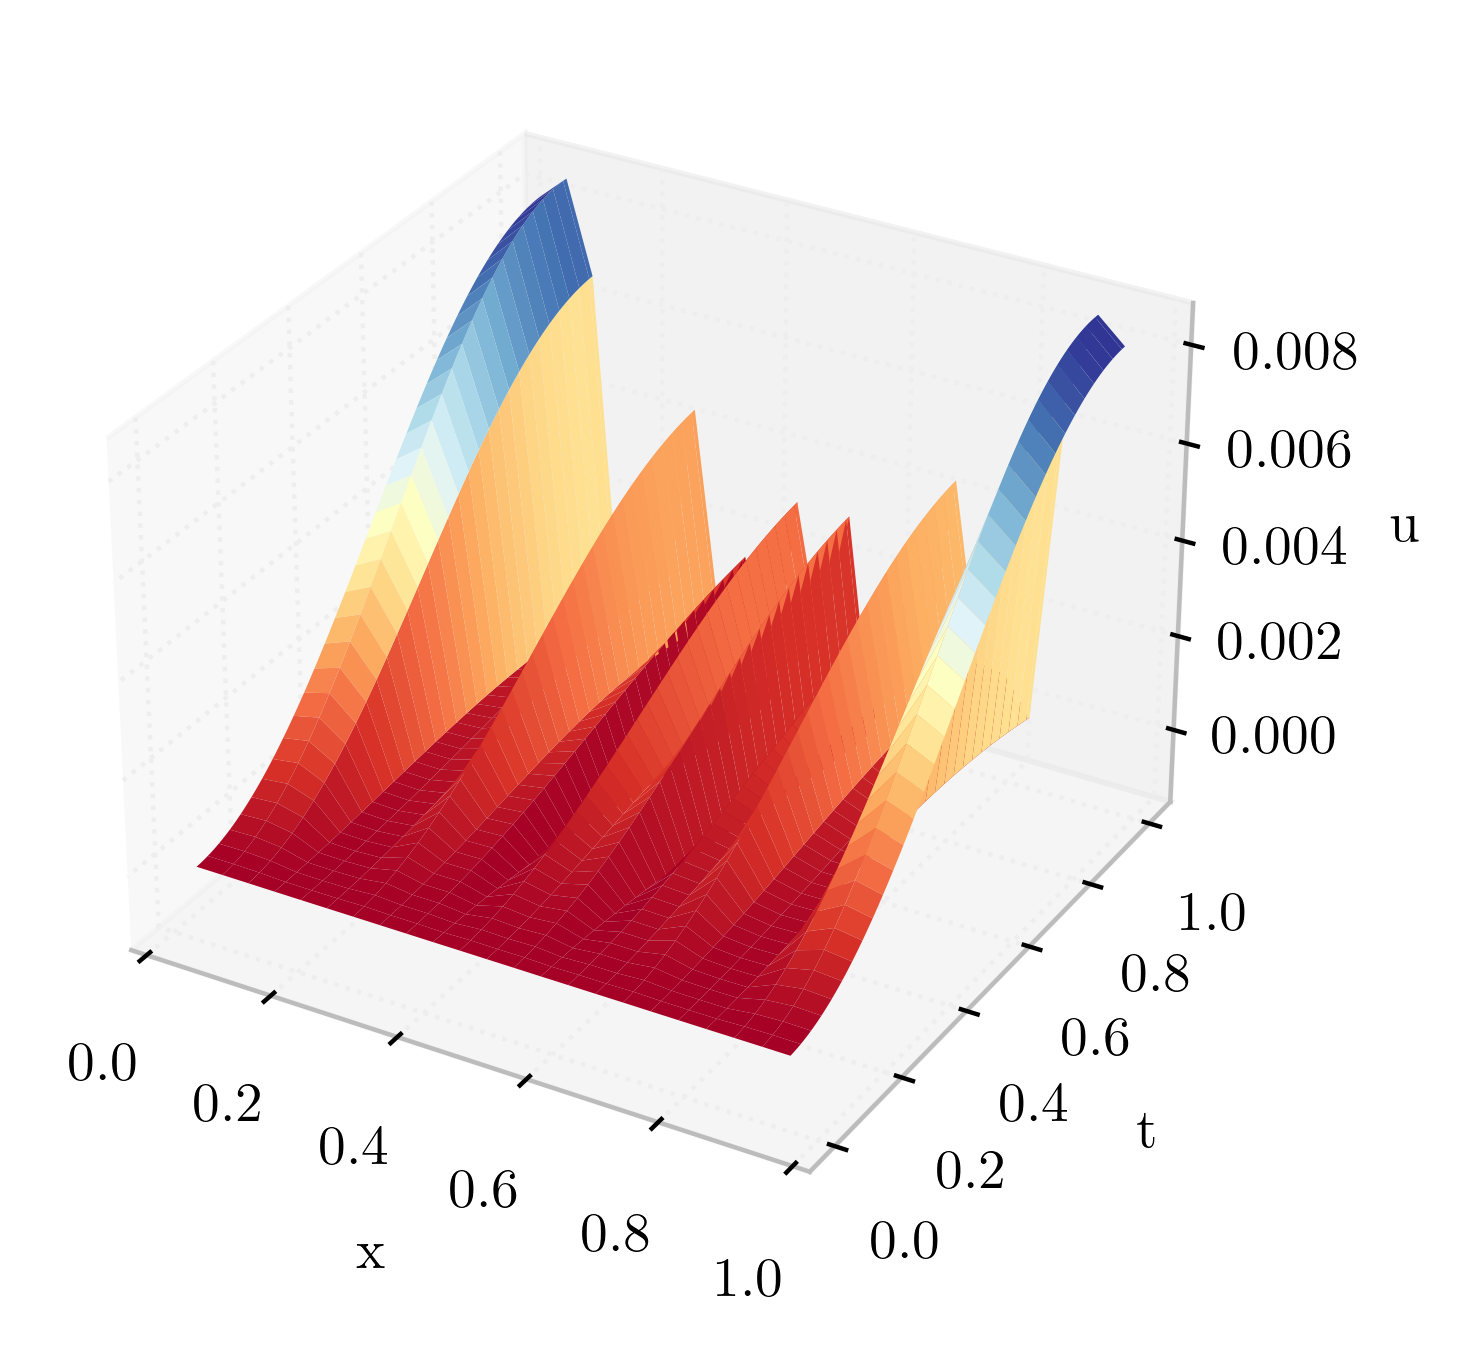

In [29]:
m228.plot.plot3d(*U.T)